<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

# Задание

Необходимо познакомиться с фреймворком машинного обучения PyTorch и выполнить три задания:
1. Регрессия по теореме универсальной аппроксимации, ручное дифференцирование
2. Бинарная классификация с помощью автодиффиренцирования PyTorch
3. Обучить полносвязную нейронную сеть классификации 3 классов изображений из набора данных CIFAR100 по варианту с точностью на тестовой выборке не менее 70%.

Для задания 3 нужно сформировать свою подвыборку CIFAR100 по варианту.

Лабораторные выполняются на платформе Google Colab - просто перейдите по ссылки в начале ноутбука. Также можно работать с ноубуками лабораторных локально.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы.

# Варианты для Задания 3
Вы должны использовать следующие классы из CIFAR100:
1. 9
2. 22
3. 47

# Контрольные вопросы
1. Что такое функция потерь
2. Что такое оптимизатор
3. Что такое активационная функция
4. Полносвязная нейронная сеть
5. Количество нейронов связей и весов в полносвязной нейронной сети
6. Что такое эпоха, итерация, батч обучения
7. Что такое тестовая, обучающая выборка
8. Как устроен набор данных, какие в нем данные и их количество
9. Что такое PyTorch
10. Обучение с учителем
11. Задачи регрессии и классификации

## Импортирование необходимых библиотек

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование

## Генерация выборки и инициализация параметров нейронной сети

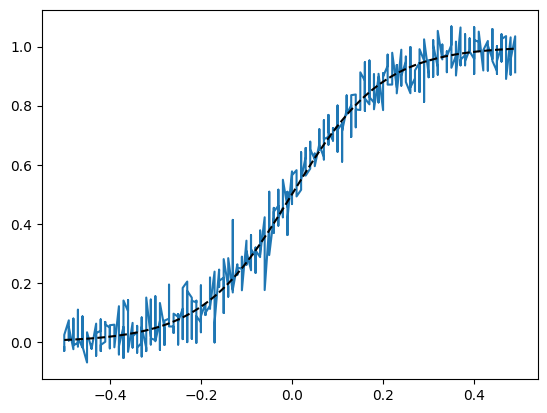

In [2]:
X = (np.arange(100)/100 - 0.5).repeat(5)

y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y

plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')
################################################
tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 64
# Инициализация весов MLP с одним скрытым слоём
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)

## Обучение нейронной сети задачи регрессии

0.002659835


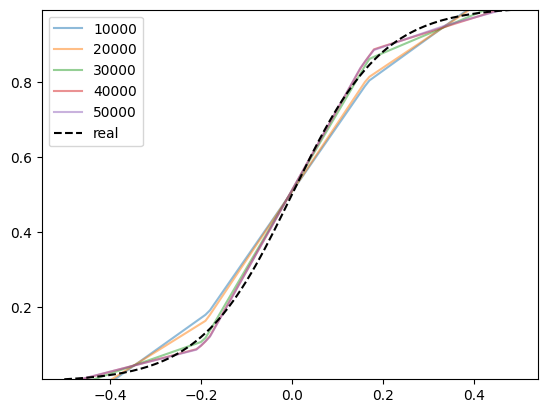

In [3]:
# Определяем функцию нелинейности
relu = lambda x: torch.maximum(x, torch.Tensor([0]))
# Прямой проход
forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                      ).sum(axis=-1,keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)

# # обратный проход
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred-y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax<=0] = 0
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    #print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2

def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

for i in range(50000): # 50 тысяч итераций градиентного спуска == 50 тысяч эпох
  output = forward(tensor_X)
  cur_loss = loss(output, tensor_y)
  grads = backward(tensor_X, tensor_y, output)
  params = [weights_1, bias_1, weights_2, bias_2]
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)
plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

# Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch

## Генерация выборки и инициализация параметров нейронной сети

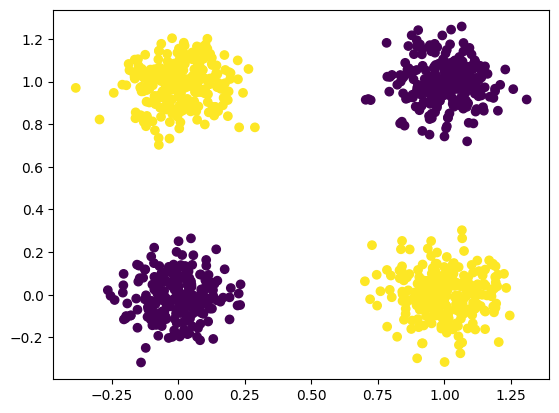

In [4]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2 # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)
plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

## Обучение нейронной сети задачи классификации

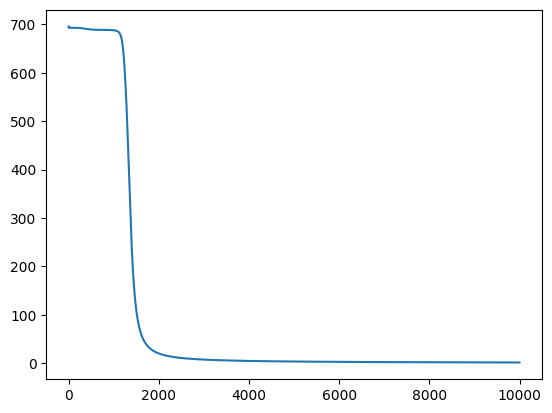

In [5]:
# Определяем функцию нелинейности
def sigmoid(x):
    return 1/(1+torch.exp(-x))

# Прямой проход
def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1,keepdims=True) + bias_2
    return sigmoid(output)
                       
# Logloss
def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()

# задаём шаг обучения
lr = 1e-3
# задаём число итераций
iters = 10000
params = [weights_1, bias_1, weights_2, bias_2]
losses = []
for i in range(iters):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward() # тут включается в работу autograd
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr # обновляем веса
        w.grad.zero_() # зануляем градиенты, чтобы не накапливались за итерации
    losses.append(lossval.item())
# выводим историю функции потерь по итерациям
plt.plot(losses)

## Проверка результатов обучения

(-0.5551136124230668, 1.4790636635310372)

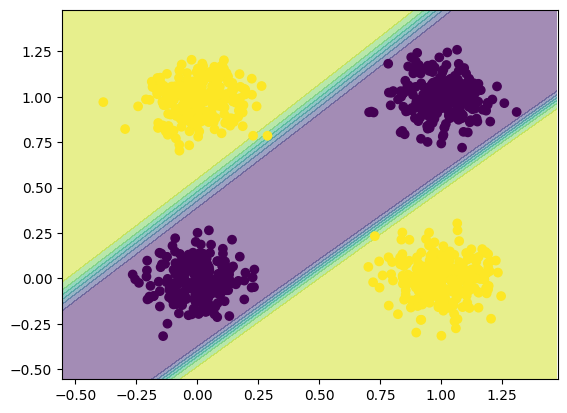

In [6]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []
# создаем точки по сетке
for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)
# получаем предсказания для всех точек
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()
# меняем форму в виде двухмерного массива
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)
# рисуем разделяющие поверхности классов
plt.contourf(xx, yy, Z, alpha=0.5)
# рисуем обучающую выборку
plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy()>0.5)
# задаём границы отображения графика
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

# Часть 3. Классификация изображений CIFAR100

## Загрузка и распаковка набора данных CIFAR100

In [9]:
!tar -xvzf cifar-100-python.tar.gz

x cifar-100-python/
x cifar-100-python/file.txt~
x cifar-100-python/train
x cifar-100-python/test
x cifar-100-python/meta


## Чтение тренировочной и тестовой выборки

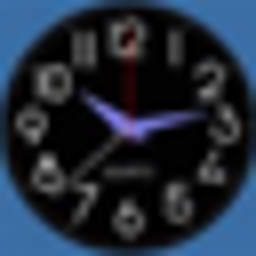

In [10]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
# 4 17 42
CLASSES = [9, 22, 47]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [11]:
batch_size = 512
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x25382fe7fd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x25382fe7ca0>}

## Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [12]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=64, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 16
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)

## Выбор функции потерь и оптимизатора градиентного спуска

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

## Обучение модели по эпохам

In [14]:
EPOCHS = 1000
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
losses = []
val_losses = []
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    losses.append(running_loss / steps_per_epoch)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_losses.append(running_loss / steps_per_epoch_val)
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,     3] loss: 1.060
[1,     1] val loss: 1.011
[2,     3] loss: 0.991
[2,     1] val loss: 0.978
[3,     3] loss: 0.956
[3,     1] val loss: 0.954
[4,     3] loss: 0.929
[4,     1] val loss: 0.934
[5,     3] loss: 0.907
[5,     1] val loss: 0.917
[6,     3] loss: 0.889
[6,     1] val loss: 0.902
[7,     3] loss: 0.871
[7,     1] val loss: 0.889
[8,     3] loss: 0.857
[8,     1] val loss: 0.877
[9,     3] loss: 0.844
[9,     1] val loss: 0.866
[10,     3] loss: 0.831
[10,     1] val loss: 0.856
[11,     3] loss: 0.820
[11,     1] val loss: 0.846
[12,     3] loss: 0.809
[12,     1] val loss: 0.837
[13,     3] loss: 0.800
[13,     1] val loss: 0.830
[14,     3] loss: 0.790
[14,     1] val loss: 0.822
[15,     3] loss: 0.781
[15,     1] val loss: 0.815
[16,     3] loss: 0.773
[16,     1] val loss: 0.809
[17,     3] loss: 0.765
[17,     1] val loss: 0.803
[18,     3] loss: 0.759
[18,     1] val loss: 0.797
[19,     3] loss: 0.752
[19,     1] val loss: 0.791
[20,     3] loss: 0.746
[20,  

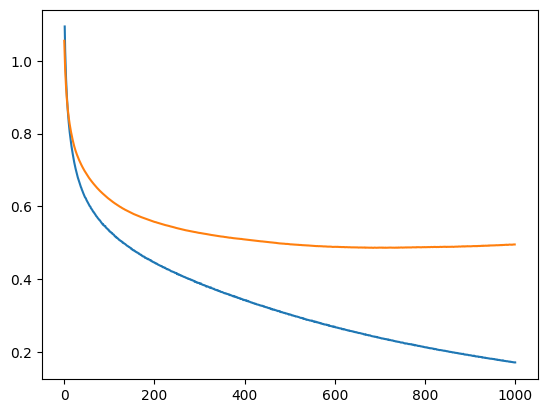

In [ ]:
plt.plot(range(1,EPOCHS+1), losses, val_losses)

## Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            print(outputs[:5])
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

[[-1.2759376e+00 -8.7809616e-01  5.6603794e+00]
 [ 2.5540349e+00 -8.0579138e-01  4.3950459e-01]
 [-3.3030846e+00  6.1025176e+00 -2.6620941e+00]
 [ 2.9257863e+00  8.2150161e-01 -4.3631285e-02]
 [ 7.5456281e+00  2.6004782e+00 -1.1275443e+00]
 [ 2.9298887e+00  1.1551312e+00 -3.0007261e-01]
 [ 1.8033848e+00  1.3830066e-01 -1.3644087e-01]
 [-2.1248276e+00  4.5308890e+00 -5.2223432e-01]
 [ 2.7618250e-01  3.5756733e+00 -1.4853619e+00]
 [-5.7076609e-01  5.5317287e+00 -4.3455849e+00]
 [ 4.9708238e+00  3.2889323e+00 -9.4749320e-01]
 [-1.5159739e+00  3.6086038e-01  1.8653185e+00]
 [-6.8205446e-02  1.2918143e+00 -1.6024533e-01]
 [ 2.9102345e+00 -6.8432963e-01 -9.0959692e-01]
 [ 6.9610448e+00 -9.8262644e-01 -3.2792485e+00]
 [-7.1612597e-02  2.8684978e+00 -1.4969307e+00]
 [ 6.5971458e-01 -5.1734018e-01  1.2944421e+00]
 [-1.6018453e+00 -1.8184813e+00  6.7759409e+00]
 [-3.2334769e+00 -1.2398143e+00  6.4315004e+00]
 [ 3.0785012e+00  1.9586025e+00 -8.5683823e-01]
 [ 1.0497222e+00  3.2910128e+00 -2.59941

## Визуализация весов

(16, 3072)


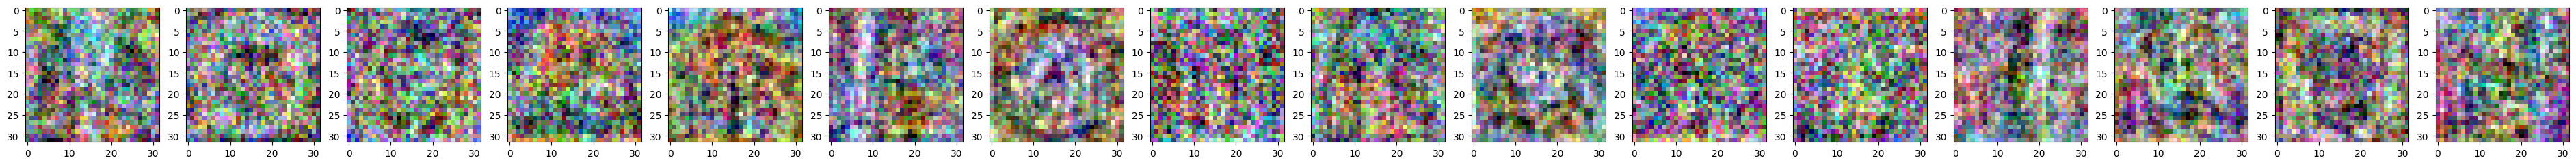

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1) 
    ax[i].imshow(ω)